In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 12,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 171MB/s]


In [8]:
# ---------------- LOSS FUNCTIONS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss for imbalanced medical data"""
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        xs_pos = x
        xs_neg = x
        
        # Asymmetric clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=0)
        
        # Basic CE calculation
        los_pos = y * torch.log(torch.sigmoid(xs_pos).clamp(min=self.eps))
        los_neg = (1 - y) * torch.log((1 - torch.sigmoid(xs_neg)).clamp(min=self.eps))
        
        # Asymmetric focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = torch.sigmoid(xs_pos) * y
            pt1 = xs_neg * (1 - y)  # pt1 = (1 - p) * (1 - y)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            loss = one_sided_w * (los_pos + los_neg)
        else:
            loss = los_pos + los_neg

        if self.reduction == 'mean':
            return -loss.mean()
        elif self.reduction == 'sum':
            return -loss.sum()
        else:
            return -loss

class ZLPRLoss(nn.Module):
    """Zero-threshold Log-sum-exp Pairwise Ranking Loss for multilabel classification"""
    def __init__(self, reduction='mean', eps=1e-8):
        super(ZLPRLoss, self).__init__()
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        """
        Args:
            logits: Model predictions (logits) of shape (batch_size, num_classes)
            targets: Ground truth labels of shape (batch_size, num_classes)
        """
        # ZLPR Loss: L_zlpr = log(1 + <y, e^(-s)>) + log(1 + <(1-y), e^s>)
        # where y is multi-hot label, s is logit vector
        
        # Positive term: log(1 + <y, e^(-s)>)
        exp_neg_logits = torch.exp(-logits)
        pos_term = torch.log(1 + torch.sum(targets * exp_neg_logits, dim=1) + self.eps)
        
        # Negative term: log(1 + <(1-y), e^s>)
        exp_logits = torch.exp(logits)
        neg_term = torch.log(1 + torch.sum((1 - targets) * exp_logits, dim=1) + self.eps)
        
        # Combine terms
        loss = pos_term + neg_term
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class CombinedLoss(nn.Module):
    """Combined Asymmetric + Focal Loss for NIH chest X-ray classification"""
    def __init__(self, focal_weight=0.3, asymmetric_weight=0.7, 
                 focal_gamma=2, asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, 
                 asymmetric_clip=0.05):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.asymmetric_weight = asymmetric_weight
        self.focal_loss = FocalLoss(gamma=focal_gamma)
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg, 
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.focal_weight * focal + self.asymmetric_weight * asymmetric

class ZLPRCombinedLoss(nn.Module):
    """Combined ZLPR + Asymmetric Loss for advanced multilabel medical classification"""
    def __init__(self, zlpr_weight=0.6, asymmetric_weight=0.4,
                 asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, asymmetric_clip=0.05):
        super(ZLPRCombinedLoss, self).__init__()
        self.zlpr_weight = zlpr_weight
        self.asymmetric_weight = asymmetric_weight
        self.zlpr_loss = ZLPRLoss()
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg,
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        zlpr = self.zlpr_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.zlpr_weight * zlpr + self.asymmetric_weight * asymmetric

In [9]:
# Using ZLPR Loss only for pure multilabel classification
criterion = ZLPRLoss(reduction='mean', eps=1e-8)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

print("Using ZLPR Loss Only")
print("- Zero-threshold Log-sum-exp Pairwise Ranking Loss")
print("- Handles label dependencies & pairwise ranking")
print("- Pure multilabel classification approach")
print("- Mathematical elegance without hyperparameter tuning")

Using ZLPR Loss Only
- Zero-threshold Log-sum-exp Pairwise Ranking Loss
- Handles label dependencies & pairwise ranking
- Pure multilabel classification approach
- Mathematical elegance without hyperparameter tuning


In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7917 | F1: 0.3633
[Validate] Cardiomegaly AUC: 0.8511 | F1: 0.3368
[Validate] Consolidation AUC: 0.8136 | F1: 0.2581
[Validate] Edema AUC: 0.9047 | F1: 0.1591
[Validate] Effusion AUC: 0.8672 | F1: 0.5145
[Validate] Emphysema AUC: 0.9018 | F1: 0.4380
[Validate] Fibrosis AUC: 0.7489 | F1: 0.1297
[Validate] Hernia AUC: 0.8949 | F1: 0.0800
[Validate] Infiltration AUC: 0.6781 | F1: 0.3756
[Validate] Mass AUC: 0.8047 | F1: 0.3169
[Validate] Nodule AUC: 0.7479 | F1: 0.3151
[Validate] Pleural_Thickening AUC: 0.7645 | F1: 0.2122
[Validate] Pneumonia AUC: 0.7229 | F1: 0.0784
[Validate] Pneumothorax AUC: 0.8756 | F1: 0.4930
[Validate] Avg AUC: 0.8120, Avg F1: 0.2908
Training Loss: 1.7633
Validation Loss: 1.6377
Validation AUC: 0.8120
Validation F1: 0.2908
✓ NEW BEST MODEL! Saved at models/best_model_20250916-164245.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8078 | F1: 0.3945
[Validate] Cardiomegaly AUC: 0.8881 | F1: 0.3526
[Validate] Consolidation AUC: 0.8174 | F1: 0.2523
[Validate] Edema AUC: 0.9129 | F1: 0.1769
[Validate] Effusion AUC: 0.8709 | F1: 0.5140
[Validate] Emphysema AUC: 0.9133 | F1: 0.4784
[Validate] Fibrosis AUC: 0.7833 | F1: 0.1457
[Validate] Hernia AUC: 0.9345 | F1: 0.3000
[Validate] Infiltration AUC: 0.6915 | F1: 0.3788
[Validate] Mass AUC: 0.8032 | F1: 0.2986
[Validate] Nodule AUC: 0.7495 | F1: 0.3259
[Validate] Pleural_Thickening AUC: 0.7779 | F1: 0.2278
[Validate] Pneumonia AUC: 0.7073 | F1: 0.1212
[Validate] Pneumothorax AUC: 0.9009 | F1: 0.5059
[Validate] Avg AUC: 0.8256, Avg F1: 0.3195
Training Loss: 1.6986
Validation Loss: 1.6286
Validation AUC: 0.8256
Validation F1: 0.3195
✓ NEW BEST MODEL! Saved at models/best_model_20250916-170914.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8120 | F1: 0.3942
[Validate] Cardiomegaly AUC: 0.8933 | F1: 0.3881
[Validate] Consolidation AUC: 0.8049 | F1: 0.2360
[Validate] Edema AUC: 0.9129 | F1: 0.1938
[Validate] Effusion AUC: 0.8774 | F1: 0.5328
[Validate] Emphysema AUC: 0.9042 | F1: 0.4986
[Validate] Fibrosis AUC: 0.7891 | F1: 0.1176
[Validate] Hernia AUC: 0.9082 | F1: 0.5000
[Validate] Infiltration AUC: 0.6953 | F1: 0.3841
[Validate] Mass AUC: 0.8186 | F1: 0.3173
[Validate] Nodule AUC: 0.7649 | F1: 0.3316
[Validate] Pleural_Thickening AUC: 0.7754 | F1: 0.2087
[Validate] Pneumonia AUC: 0.7014 | F1: 0.1022
[Validate] Pneumothorax AUC: 0.9003 | F1: 0.5019
[Validate] Avg AUC: 0.8256, Avg F1: 0.3362
Training Loss: 1.6745
Validation Loss: 1.5901
Validation AUC: 0.8256
Validation F1: 0.3362
No improvement. Patience: 1/5

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8212 | F1: 0.4066
[Validate] Cardiomegaly AUC: 0.8891 | F1: 0.3649
[Validate] Consolidation AUC: 0.8181 | F1: 0.2665
[Validate] Edema AUC: 0.9148 | F1: 0.2198
[Validate] Effusion AUC: 0.8803 | F1: 0.5394
[Validate] Emphysema AUC: 0.9147 | F1: 0.4970
[Validate] Fibrosis AUC: 0.7991 | F1: 0.1622
[Validate] Hernia AUC: 0.9780 | F1: 0.3478
[Validate] Infiltration AUC: 0.7000 | F1: 0.3849
[Validate] Mass AUC: 0.8127 | F1: 0.3413
[Validate] Nodule AUC: 0.7549 | F1: 0.3420
[Validate] Pleural_Thickening AUC: 0.7928 | F1: 0.2226
[Validate] Pneumonia AUC: 0.7138 | F1: 0.1074
[Validate] Pneumothorax AUC: 0.9027 | F1: 0.5235
[Validate] Avg AUC: 0.8352, Avg F1: 0.3376
Training Loss: 1.6593
Validation Loss: 1.6080
Validation AUC: 0.8352
Validation F1: 0.3376
✓ NEW BEST MODEL! Saved at models/best_model_20250916-180255.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8227 | F1: 0.4111
[Validate] Cardiomegaly AUC: 0.9015 | F1: 0.3792
[Validate] Consolidation AUC: 0.8230 | F1: 0.2667
[Validate] Edema AUC: 0.9174 | F1: 0.1950
[Validate] Effusion AUC: 0.8795 | F1: 0.5289
[Validate] Emphysema AUC: 0.9177 | F1: 0.4987
[Validate] Fibrosis AUC: 0.7999 | F1: 0.1680
[Validate] Hernia AUC: 0.9671 | F1: 0.5333
[Validate] Infiltration AUC: 0.6998 | F1: 0.3958
[Validate] Mass AUC: 0.8372 | F1: 0.3650
[Validate] Nodule AUC: 0.7703 | F1: 0.3425
[Validate] Pleural_Thickening AUC: 0.7833 | F1: 0.2167
[Validate] Pneumonia AUC: 0.7186 | F1: 0.0959
[Validate] Pneumothorax AUC: 0.9054 | F1: 0.5139
[Validate] Avg AUC: 0.8388, Avg F1: 0.3508
Training Loss: 1.6464
Validation Loss: 1.5763
Validation AUC: 0.8388
Validation F1: 0.3508
✓ NEW BEST MODEL! Saved at models/best_model_20250916-182922.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8210 | F1: 0.4088
[Validate] Cardiomegaly AUC: 0.8985 | F1: 0.4286
[Validate] Consolidation AUC: 0.8162 | F1: 0.2672
[Validate] Edema AUC: 0.9059 | F1: 0.1782
[Validate] Effusion AUC: 0.8793 | F1: 0.5296
[Validate] Emphysema AUC: 0.9289 | F1: 0.4772
[Validate] Fibrosis AUC: 0.8065 | F1: 0.1951
[Validate] Hernia AUC: 0.9718 | F1: 0.5333
[Validate] Infiltration AUC: 0.7074 | F1: 0.3909
[Validate] Mass AUC: 0.8185 | F1: 0.3329
[Validate] Nodule AUC: 0.7712 | F1: 0.3538
[Validate] Pleural_Thickening AUC: 0.7947 | F1: 0.2225
[Validate] Pneumonia AUC: 0.7239 | F1: 0.1034
[Validate] Pneumothorax AUC: 0.9044 | F1: 0.5046
[Validate] Avg AUC: 0.8391, Avg F1: 0.3519
Training Loss: 1.6357
Validation Loss: 1.5754
Validation AUC: 0.8391
Validation F1: 0.3519
✓ NEW BEST MODEL! Saved at models/best_model_20250916-185613.pth

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8156 | F1: 0.4073
[Validate] Cardiomegaly AUC: 0.9067 | F1: 0.4054
[Validate] Consolidation AUC: 0.8242 | F1: 0.2555
[Validate] Edema AUC: 0.9189 | F1: 0.1905
[Validate] Effusion AUC: 0.8860 | F1: 0.5324
[Validate] Emphysema AUC: 0.9292 | F1: 0.4814
[Validate] Fibrosis AUC: 0.8210 | F1: 0.1746
[Validate] Hernia AUC: 0.9787 | F1: 0.6154
[Validate] Infiltration AUC: 0.7075 | F1: 0.3921
[Validate] Mass AUC: 0.8189 | F1: 0.3212
[Validate] Nodule AUC: 0.7750 | F1: 0.3551
[Validate] Pleural_Thickening AUC: 0.7902 | F1: 0.2286
[Validate] Pneumonia AUC: 0.7163 | F1: 0.1049
[Validate] Pneumothorax AUC: 0.9068 | F1: 0.5254
[Validate] Avg AUC: 0.8425, Avg F1: 0.3564
Training Loss: 1.6261
Validation Loss: 1.5729
Validation AUC: 0.8425
Validation F1: 0.3564
✓ NEW BEST MODEL! Saved at models/best_model_20250916-192401.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8226 | F1: 0.4140
[Validate] Cardiomegaly AUC: 0.9028 | F1: 0.4000
[Validate] Consolidation AUC: 0.8153 | F1: 0.2580
[Validate] Edema AUC: 0.9079 | F1: 0.2012
[Validate] Effusion AUC: 0.8819 | F1: 0.5368
[Validate] Emphysema AUC: 0.9268 | F1: 0.5170
[Validate] Fibrosis AUC: 0.8074 | F1: 0.2112
[Validate] Hernia AUC: 0.9729 | F1: 0.5333
[Validate] Infiltration AUC: 0.7089 | F1: 0.3875
[Validate] Mass AUC: 0.8262 | F1: 0.3374
[Validate] Nodule AUC: 0.7725 | F1: 0.3408
[Validate] Pleural_Thickening AUC: 0.7978 | F1: 0.2536
[Validate] Pneumonia AUC: 0.7394 | F1: 0.1019
[Validate] Pneumothorax AUC: 0.8990 | F1: 0.4845
[Validate] Avg AUC: 0.8415, Avg F1: 0.3555
Training Loss: 1.6208
Validation Loss: 1.5859
Validation AUC: 0.8415
Validation F1: 0.3555
No improvement. Patience: 1/5

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8248 | F1: 0.4135
[Validate] Cardiomegaly AUC: 0.9031 | F1: 0.4015
[Validate] Consolidation AUC: 0.8243 | F1: 0.2845
[Validate] Edema AUC: 0.9135 | F1: 0.1860
[Validate] Effusion AUC: 0.8830 | F1: 0.5497
[Validate] Emphysema AUC: 0.9343 | F1: 0.5230
[Validate] Fibrosis AUC: 0.8119 | F1: 0.1714
[Validate] Hernia AUC: 0.9789 | F1: 0.4000
[Validate] Infiltration AUC: 0.7050 | F1: 0.3885
[Validate] Mass AUC: 0.8415 | F1: 0.3510
[Validate] Nodule AUC: 0.7646 | F1: 0.3474
[Validate] Pleural_Thickening AUC: 0.8023 | F1: 0.2503
[Validate] Pneumonia AUC: 0.7339 | F1: 0.0762
[Validate] Pneumothorax AUC: 0.8988 | F1: 0.5134
[Validate] Avg AUC: 0.8443, Avg F1: 0.3469
Training Loss: 1.6122
Validation Loss: 1.5945
Validation AUC: 0.8443
Validation F1: 0.3469
✓ NEW BEST MODEL! Saved at models/best_model_20250916-201857.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8311 | F1: 0.4299
[Validate] Cardiomegaly AUC: 0.9098 | F1: 0.4211
[Validate] Consolidation AUC: 0.8254 | F1: 0.2708
[Validate] Edema AUC: 0.9164 | F1: 0.1902
[Validate] Effusion AUC: 0.8855 | F1: 0.5549
[Validate] Emphysema AUC: 0.9390 | F1: 0.5229
[Validate] Fibrosis AUC: 0.8237 | F1: 0.2000
[Validate] Hernia AUC: 0.9807 | F1: 0.5714
[Validate] Infiltration AUC: 0.7181 | F1: 0.4006
[Validate] Mass AUC: 0.8462 | F1: 0.3563
[Validate] Nodule AUC: 0.7869 | F1: 0.3503
[Validate] Pleural_Thickening AUC: 0.8083 | F1: 0.2546
[Validate] Pneumonia AUC: 0.7293 | F1: 0.0758
[Validate] Pneumothorax AUC: 0.9013 | F1: 0.5130
[Validate] Avg AUC: 0.8501, Avg F1: 0.3651
Training Loss: 1.5755
Validation Loss: 1.5646
Validation AUC: 0.8501
Validation F1: 0.3651
✓ NEW BEST MODEL! Saved at models/best_model_20250916-204508.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8308 | F1: 0.4340
[Validate] Cardiomegaly AUC: 0.9114 | F1: 0.4331
[Validate] Consolidation AUC: 0.8227 | F1: 0.2616
[Validate] Edema AUC: 0.9154 | F1: 0.1912
[Validate] Effusion AUC: 0.8852 | F1: 0.5476
[Validate] Emphysema AUC: 0.9390 | F1: 0.5054
[Validate] Fibrosis AUC: 0.8230 | F1: 0.1990
[Validate] Hernia AUC: 0.9867 | F1: 0.5714
[Validate] Infiltration AUC: 0.7178 | F1: 0.3992
[Validate] Mass AUC: 0.8434 | F1: 0.3547
[Validate] Nodule AUC: 0.7886 | F1: 0.3545
[Validate] Pleural_Thickening AUC: 0.8063 | F1: 0.2500
[Validate] Pneumonia AUC: 0.7230 | F1: 0.0699
[Validate] Pneumothorax AUC: 0.9038 | F1: 0.5176
[Validate] Avg AUC: 0.8498, Avg F1: 0.3635
Training Loss: 1.5665
Validation Loss: 1.5684
Validation AUC: 0.8498
Validation F1: 0.3635
No improvement. Patience: 1/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8333 | F1: 0.4361
[Validate] Cardiomegaly AUC: 0.9089 | F1: 0.4151
[Validate] Consolidation AUC: 0.8257 | F1: 0.2660
[Validate] Edema AUC: 0.9136 | F1: 0.1946
[Validate] Effusion AUC: 0.8855 | F1: 0.5480
[Validate] Emphysema AUC: 0.9396 | F1: 0.5144
[Validate] Fibrosis AUC: 0.8229 | F1: 0.2244
[Validate] Hernia AUC: 0.9809 | F1: 0.5882
[Validate] Infiltration AUC: 0.7163 | F1: 0.3964
[Validate] Mass AUC: 0.8479 | F1: 0.3519
[Validate] Nodule AUC: 0.7890 | F1: 0.3429
[Validate] Pleural_Thickening AUC: 0.8113 | F1: 0.2587
[Validate] Pneumonia AUC: 0.7240 | F1: 0.0758
[Validate] Pneumothorax AUC: 0.9010 | F1: 0.5166
[Validate] Avg AUC: 0.8500, Avg F1: 0.3664
Training Loss: 1.5623
Validation Loss: 1.5640
Validation AUC: 0.8500
Validation F1: 0.3664
No improvement. Patience: 2/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8332 | F1: 0.4290
[Validate] Cardiomegaly AUC: 0.9086 | F1: 0.4245
[Validate] Consolidation AUC: 0.8276 | F1: 0.2673
[Validate] Edema AUC: 0.9171 | F1: 0.2065
[Validate] Effusion AUC: 0.8864 | F1: 0.5455
[Validate] Emphysema AUC: 0.9396 | F1: 0.5000
[Validate] Fibrosis AUC: 0.8247 | F1: 0.2079
[Validate] Hernia AUC: 0.9789 | F1: 0.5714
[Validate] Infiltration AUC: 0.7200 | F1: 0.3982
[Validate] Mass AUC: 0.8456 | F1: 0.3547
[Validate] Nodule AUC: 0.7898 | F1: 0.3478
[Validate] Pleural_Thickening AUC: 0.8112 | F1: 0.2528
[Validate] Pneumonia AUC: 0.7261 | F1: 0.0875
[Validate] Pneumothorax AUC: 0.9023 | F1: 0.5121
[Validate] Avg AUC: 0.8508, Avg F1: 0.3647
Training Loss: 1.5564
Validation Loss: 1.5607
Validation AUC: 0.8508
Validation F1: 0.3647
✓ NEW BEST MODEL! Saved at models/best_model_20250916-220433.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8321 | F1: 0.4264
[Validate] Cardiomegaly AUC: 0.9118 | F1: 0.4276
[Validate] Consolidation AUC: 0.8224 | F1: 0.2612
[Validate] Edema AUC: 0.9131 | F1: 0.1986
[Validate] Effusion AUC: 0.8855 | F1: 0.5508
[Validate] Emphysema AUC: 0.9425 | F1: 0.5077
[Validate] Fibrosis AUC: 0.8248 | F1: 0.2094
[Validate] Hernia AUC: 0.9730 | F1: 0.5882
[Validate] Infiltration AUC: 0.7223 | F1: 0.4010
[Validate] Mass AUC: 0.8450 | F1: 0.3495
[Validate] Nodule AUC: 0.7896 | F1: 0.3415
[Validate] Pleural_Thickening AUC: 0.8076 | F1: 0.2420
[Validate] Pneumonia AUC: 0.7244 | F1: 0.0788
[Validate] Pneumothorax AUC: 0.9007 | F1: 0.5145
[Validate] Avg AUC: 0.8496, Avg F1: 0.3641
Training Loss: 1.5530
Validation Loss: 1.5654
Validation AUC: 0.8496
Validation F1: 0.3641
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8335 | F1: 0.4328
[Validate] Cardiomegaly AUC: 0.9094 | F1: 0.4124
[Validate] Consolidation AUC: 0.8272 | F1: 0.2635
[Validate] Edema AUC: 0.9139 | F1: 0.2086
[Validate] Effusion AUC: 0.8846 | F1: 0.5486
[Validate] Emphysema AUC: 0.9382 | F1: 0.5077
[Validate] Fibrosis AUC: 0.8251 | F1: 0.2160
[Validate] Hernia AUC: 0.9742 | F1: 0.5714
[Validate] Infiltration AUC: 0.7212 | F1: 0.3936
[Validate] Mass AUC: 0.8462 | F1: 0.3654
[Validate] Nodule AUC: 0.7904 | F1: 0.3414
[Validate] Pleural_Thickening AUC: 0.8123 | F1: 0.2569
[Validate] Pneumonia AUC: 0.7265 | F1: 0.0840
[Validate] Pneumothorax AUC: 0.9021 | F1: 0.5186
[Validate] Avg AUC: 0.8503, Avg F1: 0.3658
Training Loss: 1.5514
Validation Loss: 1.5592
Validation AUC: 0.8503
Validation F1: 0.3658
No improvement. Patience: 2/5

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8330 | F1: 0.4386
[Validate] Cardiomegaly AUC: 0.9111 | F1: 0.4201
[Validate] Consolidation AUC: 0.8263 | F1: 0.2590
[Validate] Edema AUC: 0.9121 | F1: 0.1946
[Validate] Effusion AUC: 0.8850 | F1: 0.5411
[Validate] Emphysema AUC: 0.9364 | F1: 0.5059
[Validate] Fibrosis AUC: 0.8282 | F1: 0.2311
[Validate] Hernia AUC: 0.9729 | F1: 0.5882
[Validate] Infiltration AUC: 0.7224 | F1: 0.4000
[Validate] Mass AUC: 0.8437 | F1: 0.3531
[Validate] Nodule AUC: 0.7852 | F1: 0.3422
[Validate] Pleural_Thickening AUC: 0.8113 | F1: 0.2557
[Validate] Pneumonia AUC: 0.7265 | F1: 0.0851
[Validate] Pneumothorax AUC: 0.9036 | F1: 0.5171
[Validate] Avg AUC: 0.8498, Avg F1: 0.3666
Training Loss: 1.5467
Validation Loss: 1.5525
Validation AUC: 0.8498
Validation F1: 0.3666
No improvement. Patience: 3/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8315 | F1: 0.4323
[Validate] Cardiomegaly AUC: 0.9104 | F1: 0.4252
[Validate] Consolidation AUC: 0.8265 | F1: 0.2652
[Validate] Edema AUC: 0.9125 | F1: 0.2018
[Validate] Effusion AUC: 0.8841 | F1: 0.5443
[Validate] Emphysema AUC: 0.9326 | F1: 0.5104
[Validate] Fibrosis AUC: 0.8249 | F1: 0.2251
[Validate] Hernia AUC: 0.9749 | F1: 0.5882
[Validate] Infiltration AUC: 0.7211 | F1: 0.3952
[Validate] Mass AUC: 0.8475 | F1: 0.3578
[Validate] Nodule AUC: 0.7903 | F1: 0.3460
[Validate] Pleural_Thickening AUC: 0.8146 | F1: 0.2530
[Validate] Pneumonia AUC: 0.7252 | F1: 0.0903
[Validate] Pneumothorax AUC: 0.9043 | F1: 0.5164
[Validate] Avg AUC: 0.8500, Avg F1: 0.3679
Training Loss: 1.5459
Validation Loss: 1.5593
Validation AUC: 0.8500
Validation F1: 0.3679
No improvement. Patience: 4/5

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/12993 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/736 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8328 | F1: 0.4326
[Validate] Cardiomegaly AUC: 0.9125 | F1: 0.4082
[Validate] Consolidation AUC: 0.8201 | F1: 0.2530
[Validate] Edema AUC: 0.9115 | F1: 0.2014
[Validate] Effusion AUC: 0.8829 | F1: 0.5395
[Validate] Emphysema AUC: 0.9345 | F1: 0.5039
[Validate] Fibrosis AUC: 0.8260 | F1: 0.2209
[Validate] Hernia AUC: 0.9655 | F1: 0.6250
[Validate] Infiltration AUC: 0.7227 | F1: 0.3973
[Validate] Mass AUC: 0.8491 | F1: 0.3548
[Validate] Nodule AUC: 0.7920 | F1: 0.3451
[Validate] Pleural_Thickening AUC: 0.8124 | F1: 0.2517
[Validate] Pneumonia AUC: 0.7268 | F1: 0.0778
[Validate] Pneumothorax AUC: 0.9004 | F1: 0.4984
[Validate] Avg AUC: 0.8492, Avg F1: 0.3650
Training Loss: 1.5400
Validation Loss: 1.5634
Validation AUC: 0.8492
Validation F1: 0.3650
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


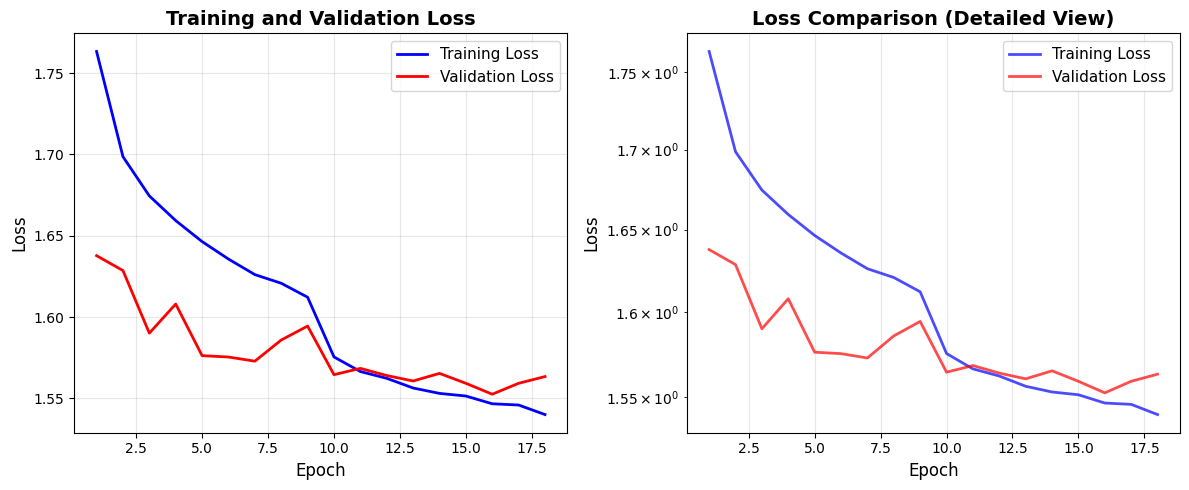


===== TRAINING SUMMARY =====
Final Training Loss: 1.5400
Final Validation Loss: 1.5634
Best Validation AUC: 0.8508
Total Epochs Trained: 18
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8095 | F1: 0.3876
[Test] Cardiomegaly AUC: 0.9276 | F1: 0.4945
[Test] Consolidation AUC: 0.7748 | F1: 0.2083
[Test] Edema AUC: 0.8779 | F1: 0.2353
[Test] Effusion AUC: 0.8986 | F1: 0.6137
[Test] Emphysema AUC: 0.9630 | F1: 0.5419
[Test] Fibrosis AUC: 0.8619 | F1: 0.1605
[Test] Hernia AUC: 0.9979 | F1: 0.7778
[Test] Infiltration AUC: 0.7049 | F1: 0.4066
[Test] Mass AUC: 0.8989 | F1: 0.4396
[Test] Nodule AUC: 0.7814 | F1: 0.3226
[Test] Pleural_Thickening AUC: 0.8004 | F1: 0.2577
[Test] Pneumonia AUC: 0.7009 | F1: 0.0604
[Test] Pneumothorax AUC: 0.8787 | F1: 0.3609
[Test] Avg AUC: 0.8483, Avg F1: 0.3762


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 1.6344
Avg AUROC : 0.8483
Avg F1    : 0.3762

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8095     0.3876     0.2169    
Cardiomegaly         0.9276     0.4945     0.1092    
Consolidation        0.7748     0.2083     0.2530    
Edema                0.8779     0.2353     0.2070    
Effusion             0.8986     0.6137     0.3303    
Emphysema            0.9630     0.5419     0.1319    
Fibrosis             0.8619     0.1605     0.1131    
Hernia               0.9979     0.7778     0.3643    
Infiltration         0.7049     0.4066     0.2699    
Mass                 0.8989     0.4396     0.4872    
Nodule               0.7814     0.3226     0.1628    
Pleural_Thickening   0.8004     0.2577     0.1431    
Pneumonia            0.7009     0.0604     0.0488    
Pneumothorax         0.8787     0.3609     0.2769    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

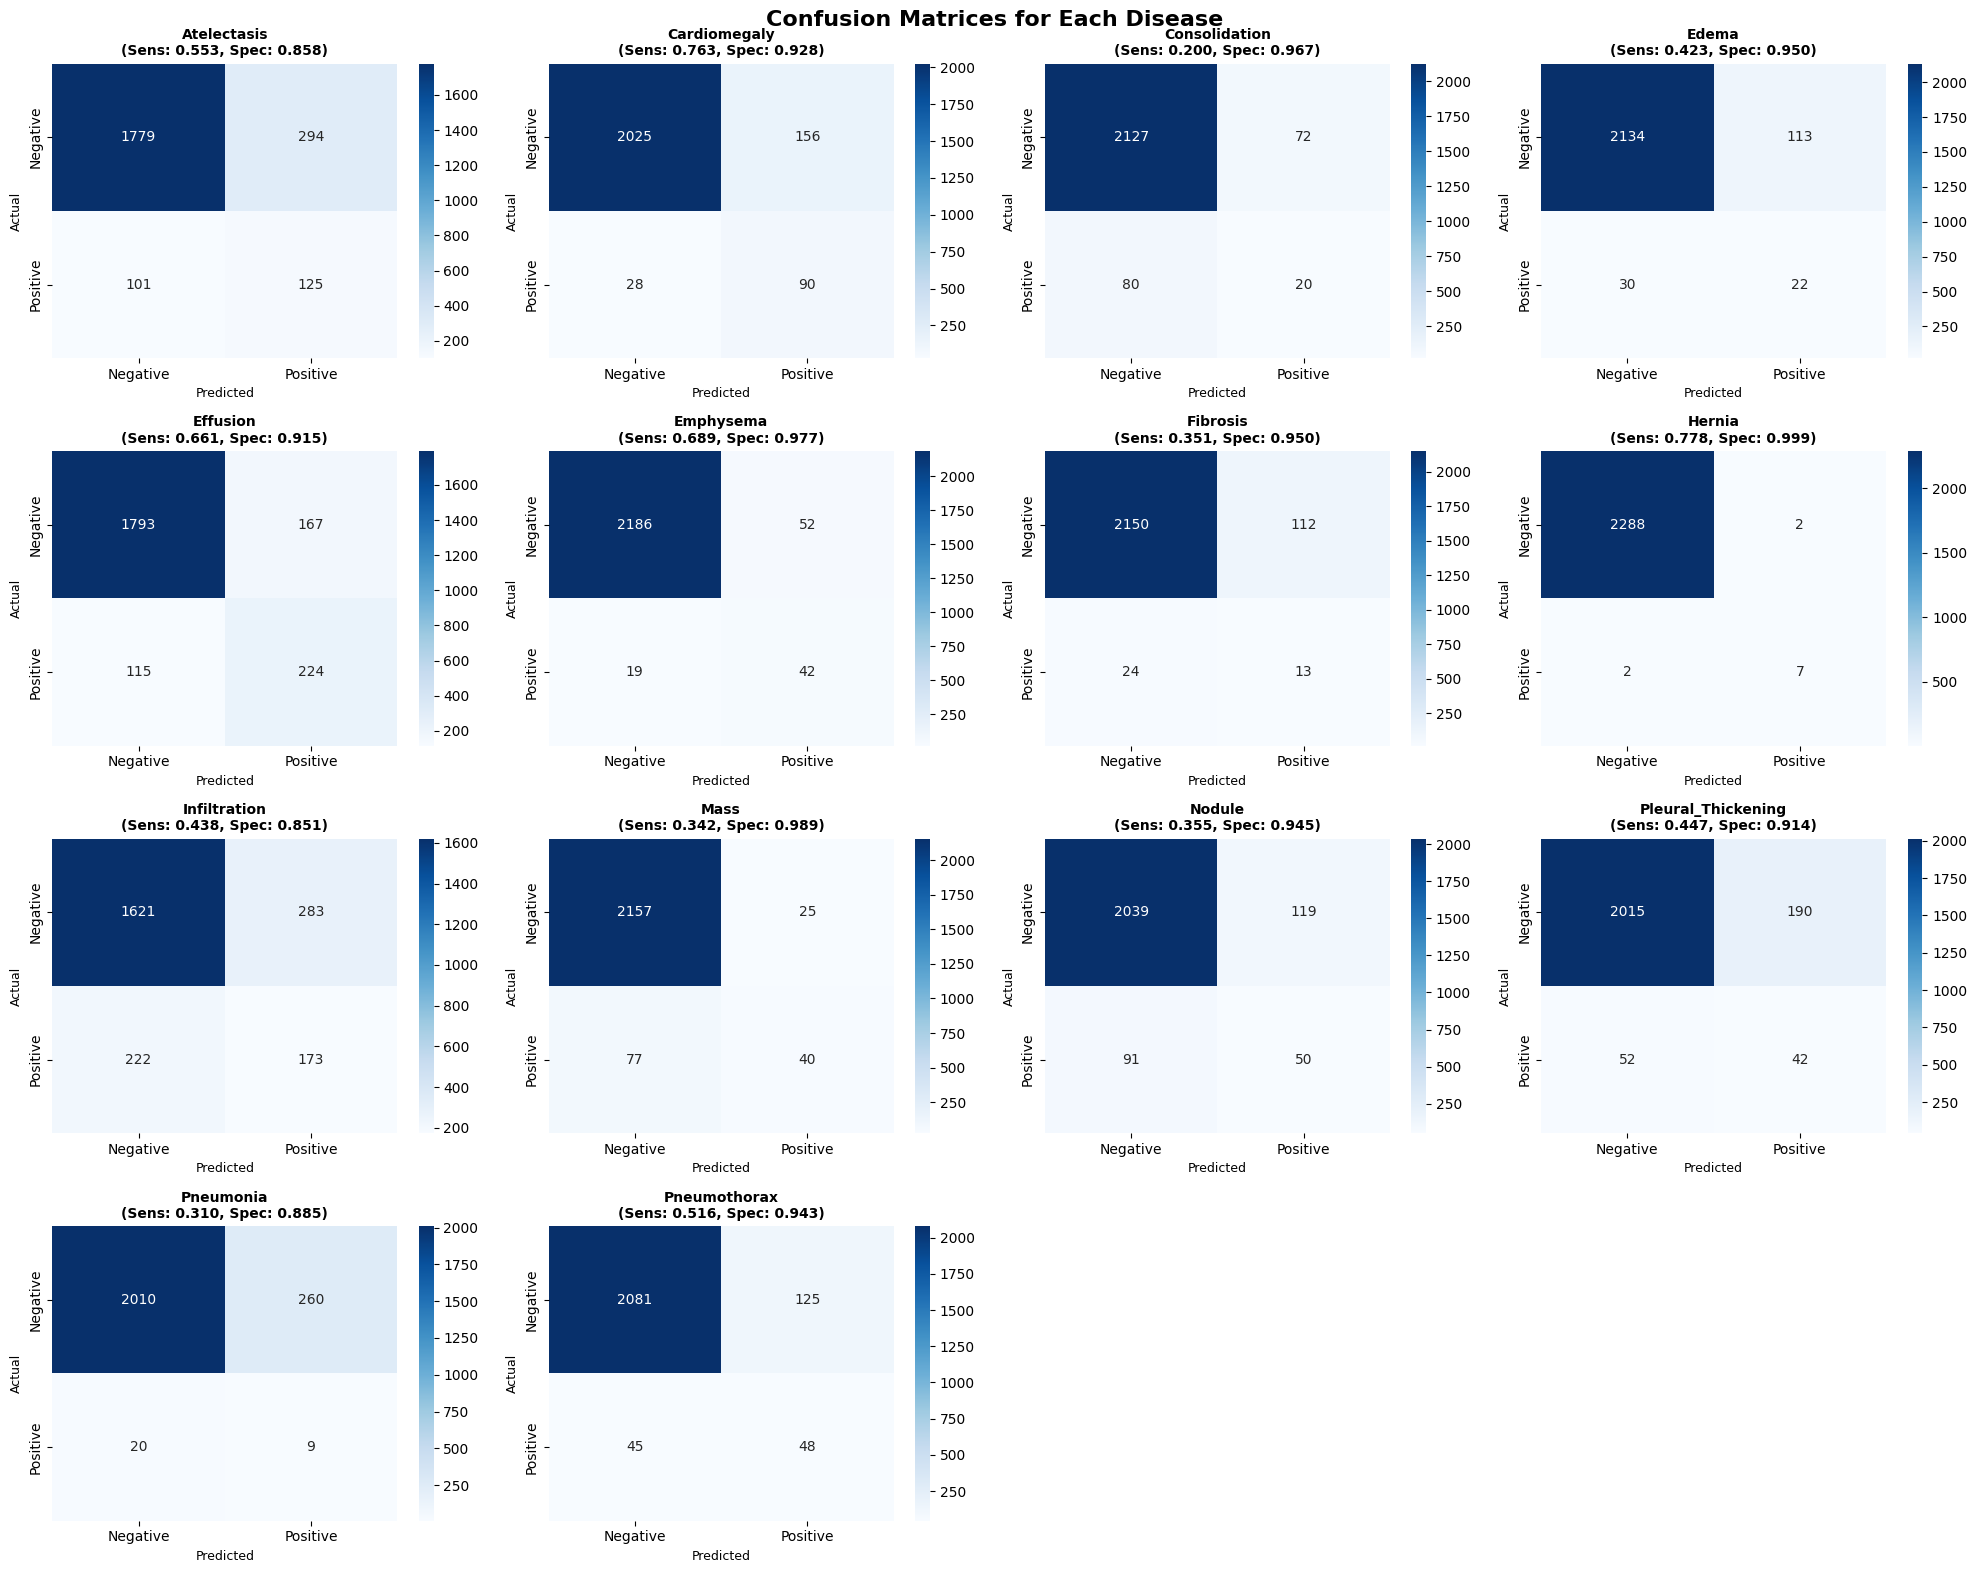

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          125    1779   294    101    0.553    0.858    0.298    0.946   
Cardiomegaly         90     2025   156    28     0.763    0.928    0.366    0.986   
Consolidation        20     2127   72     80     0.200    0.967    0.217    0.964   
Edema                22     2134   113    30     0.423    0.950    0.163    0.986   
Effusion             224    1793   167    115    0.661    0.915    0.573    0.940   
Emphysema            42     2186   52     19     0.689    0.977    0.447    0.991   
Fibrosis             13     2150   112    24     0.351    0.950    0.104    0.989   
Hernia               7      2288   2      2      0.778    0.999    0.778    0.999   
Infiltration         173    1621   283    222    0.438    0.851    0.379    0.880   
Ma